In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score

In [ ]:
from transformers import MT5ForConditionalGeneration, MT5Tokenizer,AutoTokenizer
from transformers import TrainingArguments, Trainer,Seq2SeqTrainingArguments, Seq2SeqTrainer, EvalPrediction
from datasets import load_dataset, Dataset
import torch
import evaluate
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset

# 1-Cargar el modelo y tokenizador
Se carga el modelo google/mt5-small
https://huggingface.co/google/mt5-small

In [ ]:
#Cargar los datos del modelo
model_MT5 = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
# Tokenización
tokenizer_MT5 = AutoTokenizer.from_pretrained("google/mt5-small",use_fast=False,legacy=False)
# Documentación error tokenizer SentencePiece
#https://github.com/huggingface/transformers/pull/24565

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 2-Cargar el dataset

In [ ]:
# Cargar el dataset
data_path = "/content/drive/MyDrive/TFM_Pruebas_Investigación/02-FineTunning_mtT5/T5-abstractivo-procesar.csv"  # Ruta al archivo CSV
df_MT5 = pd.read_csv(data_path, sep=";", encoding="utf-8")
pd.set_option("display.max_colwidth", None)  # Esto es para no truncar la columna de respuesta

print(df_MT5 .head())

                                                                                                 context  \
0  La importación es la entrada de mercancías procedentes de terceros países dentro de la Unión Europea.   
1  La importación es la entrada de mercancías procedentes de terceros países dentro de la Unión Europea.   
2  La importación es la entrada de mercancías procedentes de terceros países dentro de la Unión Europea.   
3  La importación es la entrada de mercancías procedentes de terceros países dentro de la Unión Europea.   
4  La importación es la entrada de mercancías procedentes de terceros países dentro de la Unión Europea.   

                                   question  \
0          ¿Cómo se define una importación?   
1    ¿Qué significa el término importación?   
2         ¿Qué se entiende por importación?   
3  ¿Qué implica el concepto de importación?   
4          ¿Qué representa una importación?   

                                                                    

# 3-Aplicar función de procesamiento y batch de datos de huggingface

In [ ]:
train_df, eval_df = train_test_split(df_MT5,test_size=0.3)

# Convertir DataFrames a objetos Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(eval_df)

def preprocess_data(examples):
    # Combinar el contexto y la pregunta como entrada del modelo
    inputs = [f"context: {context} question: {question}" for context, question in zip(examples["context"], examples["question"])]
    targets = examples["answer"]
    model_inputs = tokenizer_MT5(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer_MT5(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Preprocesar ambos conjunto aplicando la clase map con la función procesamiento creada
train_dataset = train_dataset.map(preprocess_data, batched=True)
eval_dataset = val_dataset.map(preprocess_data, batched=True)




Map:   0%|          | 0/6053 [00:00<?, ? examples/s]

Map:   0%|          | 0/2595 [00:00<?, ? examples/s]

In [ ]:

ejemplo_procesado = train_dataset[99]
print(ejemplo_procesado)
print(ejemplo_procesado.keys())



{'context': 'Una importación se declara en la casilla 77 del modelo 303.', 'question': 'No sé cómo registrar una importación.', 'answer': 'La casilla 77 del modelo 303 está destinada a las importaciones.', '__index_level_0__': 836, 'input_ids': [19730, 267, 6056, 12058, 1434, 303, 25671, 289, 283, 5198, 2960, 9699, 426, 13734, 75744, 260, 7680, 267, 653, 3190, 885, 1233, 259, 78763, 573, 12058, 1434, 260, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# 4-Entrenamiento y definición de métricas

In [ ]:
from evaluate import load
import numpy as np
#¿se arreglarán los errores de desbordamiento de memoria con esto?
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# Función para calcular métricas personalizadas
metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    """
    Función para computar BLEU y ROUGE a partir de las predicciones del modelo.
     Si en training_args se define 'include_inputs_for_metrics=True' entonces:
        predictions, labels, inputs
     Else
        predictions, labels

    Solo evaluamos el texto decodificado, así que no nos hace falta --> False
    """
    predictions, labels = eval_preds

    # Por una incidencia de autotokenizer documentada en Huggingface los tokens especiales de pad se tokenizan como -100.
    # Se reemplaza manualmente por ID del token de padding (pad_token_id) para no afectar la decodificación
    # SI NO SE HACE ESTO, OBTENDREMOS ERRORES DE ID de token fuera de rango
    labels = np.where(labels != -100, labels, tokenizer_MT5.pad_token_id)
    predictions = np.where(predictions != -100, predictions, tokenizer_MT5.pad_token_id)
    """
    Para depuración
    print(tokenizer_MT5.pad_token_id)
    print("Max prediction ID:", np.max(predictions))
    print("Min prediction ID:", np.min(predictions))
    print("Vocab size:", tokenizer_MT5.vocab_size)
    """
    # Decodificar predicciones y etiquetas
    pred_str = tokenizer_MT5.batch_decode(predictions, skip_special_tokens=True)
    label_str = tokenizer_MT5.batch_decode(labels, skip_special_tokens=True)

    # SacreBLEU trabaja con listas
    references = [[ref] for ref in label_str]

    # Cálculo de BLEU
    bleu_result = metric.compute(
        predictions=pred_str,
        references=references
    )

    # Cálculo de ROUGE
    rouge_result = rouge_metric.compute(
        predictions=pred_str,
        references=label_str
    )

    # Representar métricas en cada epoch del entrenamiento
    return {
        "bleu": bleu_result["score"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "rougeLsum": rouge_result["rougeLsum"]
    }


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_MT5.to(device)
"""
checkpoint 2
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/TFM_Pruebas_Investigación/02-FineTunning_mtT5/mt5Fine-intermedios",
    evaluation_strategy="epoch", #steps: evaluar al final de x steps / epoch: evaluar al final de la epoch
    #eval_steps=200,
    optim="adamw_torch",
    per_device_train_batch_size=18,
    warmup_steps=100,
    per_device_eval_batch_size=8, # batch = per_device_train_batch_size × gradient_accumulation_steps × nº GPUs
    gradient_accumulation_steps=8,
    num_train_epochs=30,
    gradient_checkpointing=True,
    eval_accumulation_steps=2,
    predict_with_generate=True,
    group_by_length=True,
    learning_rate = 5e-4,
    weight_decay=0.001,
    dataloader_num_workers=2,
    dataloader_pin_memory=False,
    generation_num_beams=4,
    report_to="none", #Para evitar usar la API de weights and biases
    include_inputs_for_metrics=False,
    metric_for_best_model="bleu"
    #metric_for_best_model="eval_loss"
)
"""

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/TFM_Pruebas_Investigación/02-FineTunning_mtT5/mt5Fine-intermedios",
    evaluation_strategy="epoch", #steps: evaluar al final de x steps / epoch: evaluar al final de la epoch
    #eval_steps=200,
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.999,
    per_device_train_batch_size=18,
    warmup_steps=100,
    logging_steps=35,
    per_device_eval_batch_size=8, # batch = per_device_train_batch_size × gradient_accumulation_steps × nº GPUs
    gradient_accumulation_steps=8,
    num_train_epochs=30,
    gradient_checkpointing=True,
    eval_accumulation_steps=2,
    predict_with_generate=True,
    group_by_length=True,
    learning_rate = 8e-4,
    weight_decay=0.001,
    dataloader_num_workers=2,
    dataloader_pin_memory=False,
    generation_num_beams=4,
    report_to="none", #Para evitar usar la API de weights and biases
    include_inputs_for_metrics=False,
    metric_for_best_model="bleu"
    #metric_for_best_model="eval_loss"
)
# Crear el Trainer
trainer = Seq2SeqTrainer(
    model=model_MT5,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer_MT5,
    compute_metrics=compute_metrics  # Usar la función de métricas personalizadas
)

# Entrenar el modelo
trainer.train()
result = trainer.evaluate()
print(result)
trainer.save_model("/content/drive/MyDrive/TFM_Pruebas_Investigación/02-FineTunning_mtT5/02-GeneradorRespuesta-mt5")  # Guarda el modelo final

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-c65865c7cd87>:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel,Rougelsum
1,34.895600,12.683458,2.570747,0.165420,0.073156,0.144325,0.144247


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel,Rougelsum
1,34.895600,12.683458,2.570747,0.165420,0.073156,0.144325,0.144247
2,12.632900,3.247332,0.040597,0.088296,0.004385,0.077863,0.077895
3,3.812200,2.150491,0.001744,0.058063,0.000020,0.053949,0.053945
4,2.384100,1.042927,0.392404,0.173806,0.072011,0.147838,0.147805
5,0.750600,0.175876,3.049723,0.230844,0.101065,0.192324,0.191915
6,0.240000,0.049913,2.665998,0.246273,0.109013,0.200090,0.200143
7,0.109400,0.030834,3.913195,0.298970,0.159410,0.239274,0.239241
8,0.069900,0.027805,6.043341,0.333675,0.202546,0.272348,0.272552
9,0.048600,0.025555,6.109857,0.343080,0.201366,0.275810,0.275874
10,0.040000,0.024730,7.034570,0.369949,0.233741,0.305692,0.305669


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.01470922864973545, 'eval_bleu': 8.617671931676677, 'eval_rouge1': 0.4214668127346236, 'eval_rouge2': 0.2911139842346481, 'eval_rougeL': 0.3597725082242609, 'eval_rougeLsum': 0.35986501674052335, 'eval_runtime': 173.2527, 'eval_samples_per_second': 14.978, 'eval_steps_per_second': 1.876, 'epoch': 29.30860534124629}


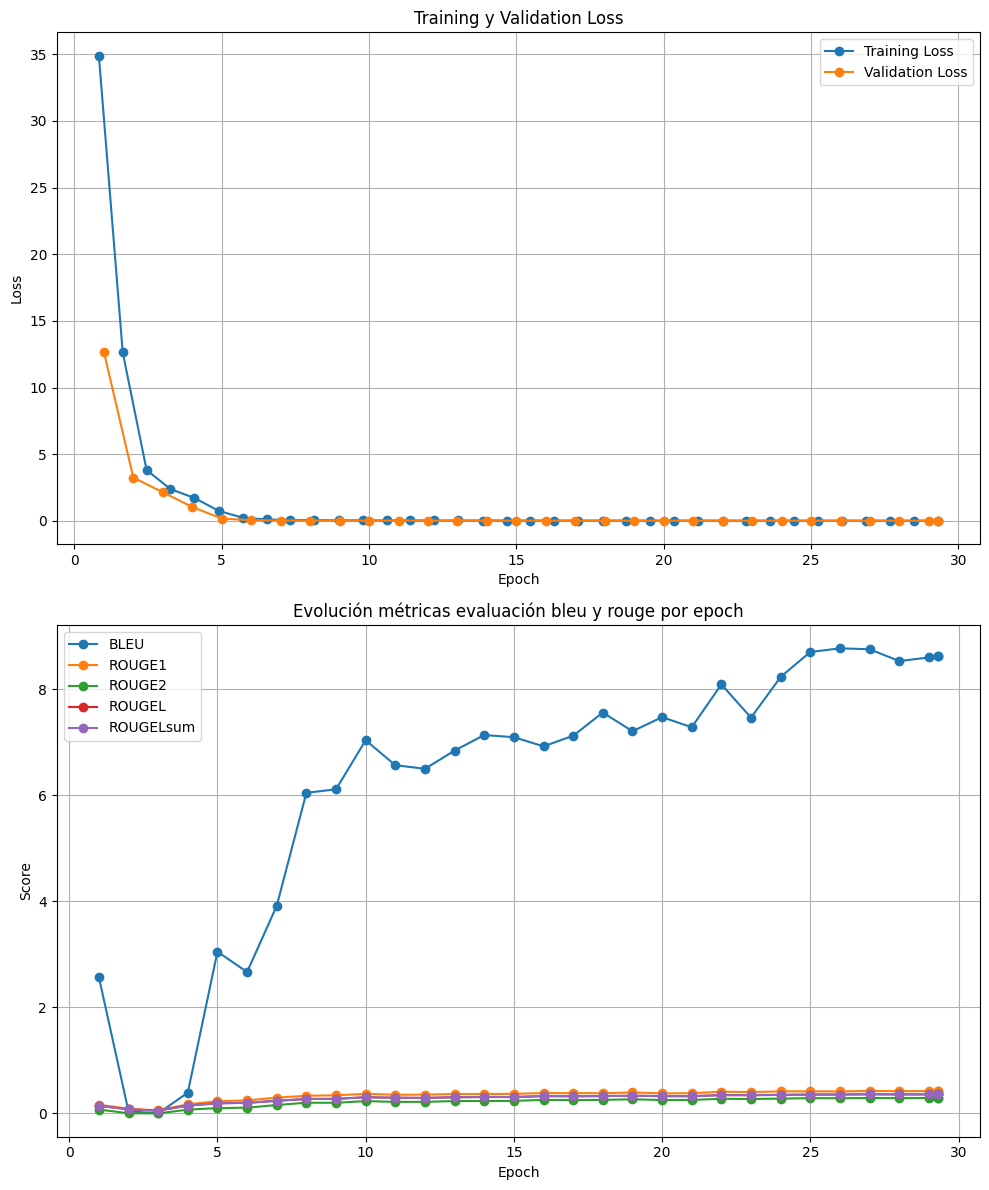

In [ ]:
import matplotlib.pyplot as plt

# Extraer el historial de logs
log_history = trainer.state.log_history

# Listas para almacenar las métricas evaluadas en cada epoch
train_epochs = []
train_loss = []

eval_epochs = []
eval_loss = []
eval_bleu = []
eval_rouge1 = []
eval_rouge2 = []
eval_rougeL = []
eval_rougeLsum = []

# Recorrer historial con valores de eval

for log in log_history:
    # Cuando se registra 'loss' (training loss) y 'epoch' se trata de un log de entrenamiento
    if 'loss' in log and 'epoch' in log:
        train_epochs.append(log['epoch'])
        train_loss.append(log['loss'])

    # Cuando aparece 'eval_loss', sabemos que es un log de evaluación
    if 'eval_loss' in log:
        eval_epochs.append(log['epoch'])
        eval_loss.append(log['eval_loss'])

        # Extraer los valores de las métricas
        eval_bleu.append(log.get('eval_bleu', None))
        eval_rouge1.append(log.get('eval_rouge1', None))
        eval_rouge2.append(log.get('eval_rouge2', None))
        eval_rougeL.append(log.get('eval_rougeL', None))
        eval_rougeLsum.append(log.get('eval_rougeLsum', None))

# 2 subplots: uno para las pérdidas y otro para las métricas
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# -----------------------------------------------------------------------------------
# 1) Subgráfico con las pérdidas de entrenamiento y validación
axes[0].plot(train_epochs, train_loss, label='Training Loss', marker='o')
axes[0].plot(eval_epochs, eval_loss, label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training y Validation Loss')
axes[0].legend()
axes[0].grid(True)

# -----------------------------------------------------------------------------------
# 2) Subgráfico con las métricas de evaluación
# Rouge y bleu estan fuera de escala. Si da tiempo, darle una vuelta para arreglarlo.
axes[1].plot(eval_epochs, eval_bleu, label='BLEU', marker='o')
axes[1].plot(eval_epochs, eval_rouge1, label='ROUGE1', marker='o')
axes[1].plot(eval_epochs, eval_rouge2, label='ROUGE2', marker='o')
axes[1].plot(eval_epochs, eval_rougeL, label='ROUGEL', marker='o')
axes[1].plot(eval_epochs, eval_rougeLsum, label='ROUGELsum', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Evolución métricas evaluación bleu y rouge por epoch')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
result = trainer.evaluate()
print(result)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 0.014710414223372936, 'eval_bleu': 8.617671931676677, 'eval_rouge1': 0.42183274512255803, 'eval_rouge2': 0.29076580313410916, 'eval_rougeL': 0.3597208937660097, 'eval_rougeLsum': 0.35963637536884885, 'eval_runtime': 174.5762, 'eval_samples_per_second': 14.865, 'eval_steps_per_second': 1.862, 'epoch': 29.30860534124629}


In [ ]:
def generate_answer(context, question):
    input_text = f"contexto: {context} pregunta: {question}"
    inputs = tokenizer_MT5(input_text, return_tensors="pt", max_length=512, truncation=True)

     # Mover inputs a la GPU, si estuviese disponible
    for key in inputs:
        inputs[key] = inputs[key].to(model_MT5.device)

    outputs = model_MT5.generate(**inputs, max_length=256, num_beams=3, no_repeat_ngram_size=2, early_stopping=True)
    return tokenizer_MT5.decode(outputs[0], skip_special_tokens=True)
"""
# Lista de tokens a bloquear
bad_words = ["<extra_id_0>", "<extra_id_1>"]
bad_words_ids = tokenizer_MT5(bad_words, add_special_tokens=False).input_ids
"""

In [ ]:
# Ejemplo
context = "La importación es la entrada de mercancías procedentes de terceros países dentro de la Unión Europea."
question = "Qué es una importacion"
print(generate_answer(context, question))

Importar es el acto de introducir bienes provenientes de países ajenos a la Unión Europea.
